In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.metrics import  make_scorer, confusion_matrix
import shap as sh
import optuna
import joblib

c:\Users\SUJAL GULIA\anaconda3\envs\amyloid_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df=pd.read_csv('final1.csv')

x=df[[col for col in df.columns if col.startswith('Morgan')] +
       [col for col in df.columns if col.startswith('MACCS')] +
       [col for col in df.columns if col.startswith('RDKitFP')]]
y=df['Activity Label']

x_shuffled, y_shuffled = shuffle(x, y, random_state=42)

x_train, x_test, y_train, y_test = train_test_split(x_shuffled, y_shuffled, test_size=0.2, stratify=y_shuffled, random_state=42)

[LightGBM] [Info] Number of positive: 6476, number of negative: 3653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 10129, number of used features: 462
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639352 -> initscore=0.572554
[LightGBM] [Info] Start training from score 0.572554
Classification Report for LGBM:

              precision    recall  f1-score   support

           0       0.78      0.74      0.76       914
           1       0.86      0.88      0.87      1619

    accuracy                           0.83      2533
   macro avg       0.82      0.81      0.82      2533
weighted avg       0.83      0.83      0.83      2533

Classification Report for XGBoost:

              precision    recall  f1-score   supp

c:\Users\SUJAL GULIA\anaconda3\envs\amyloid_venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.75      0.68      0.72       914
           1       0.83      0.87      0.85      1619

    accuracy                           0.81      2533
   macro avg       0.79      0.78      0.78      2533
weighted avg       0.80      0.81      0.80      2533

Classification Report for K Neighbor Classifier:

              precision    recall  f1-score   support

           0       0.79      0.72      0.76       914
           1       0.85      0.89      0.87      1619

    accuracy                           0.83      2533
   macro avg       0.82      0.81      0.81      2533
weighted avg       0.83      0.83      0.83      2533

Classification Report for SVC:

              precision    recall  f1-score   support

           0       0.79      0.73      0.76       914
           1       0.86      0.89      0.87      1619

    accuracy                           0.83      253

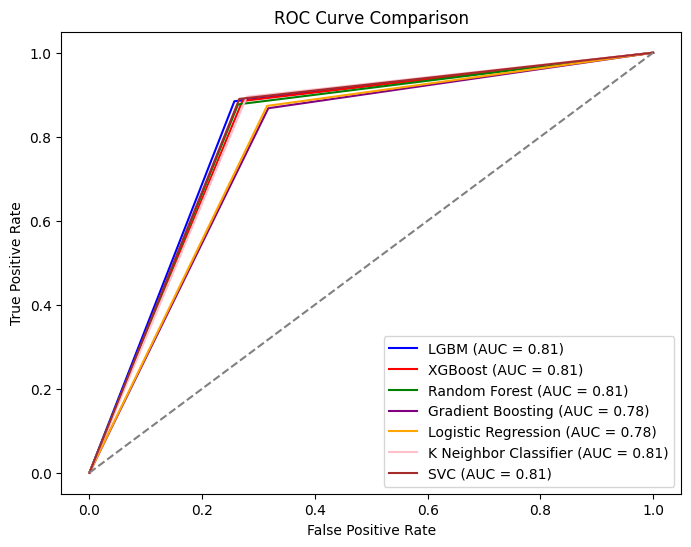

In [4]:
models = {
    "LGBM": (LGBMClassifier(random_state=42), 'blue'),
    "XGBoost": (xgb.XGBClassifier(random_state=42), 'red'),
    "Random Forest": (RandomForestClassifier(random_state=42), 'green'),
    "Gradient Boosting": (GradientBoostingClassifier(random_state=42), 'purple'),
    "Logistic Regression": (LogisticRegression(), 'orange'),
    "K Neighbor Classifier": (KNeighborsClassifier(), 'pink'),
    "SVC": (SVC(), 'brown')
}

plt.figure(figsize=(8, 6))

for name, (model, color) in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color=color, label=f'{name} (AUC = {roc_auc:.2f})')

    print(f"Classification Report for {name}:\n")
    print(classification_report(y_test, y_pred))

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

Taking ensemble models from model_comparison, ensembled on the basis of error correlation

In [4]:
ensemble1 = VotingClassifier(
    estimators=[('lgbm', LGBMClassifier()), ('rf', RandomForestClassifier()), ('knn', KNeighborsClassifier())],
    voting='soft'
)
ensemble1.fit(x_train, y_train)
final_pred = ensemble1.predict(x_test)

print(classification_report(y_test, final_pred))
print("ROC AUC Score:", roc_auc_score(y_test, final_pred))

[LightGBM] [Info] Number of positive: 6476, number of negative: 3653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 10129, number of used features: 462
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639352 -> initscore=0.572554
[LightGBM] [Info] Start training from score 0.572554
              precision    recall  f1-score   support

           0       0.80      0.74      0.76       914
           1       0.86      0.89      0.87      1619

    accuracy                           0.84      2533
   macro avg       0.83      0.81      0.82      2533
weighted avg       0.83      0.84      0.84      2533

ROC AUC Score: 0.8144956702613791


In [6]:
ensemble2=VotingClassifier(
    estimators=[('xgb', xgb.XGBClassifier()), ('svc', SVC(probability=True))],
    voting='soft'
)

ensemble2.fit(x_train, y_train)
final_pred = ensemble2.predict(x_test)

print(classification_report(y_test, final_pred))
print("ROC AUC Score:", roc_auc_score(y_test, final_pred))

              precision    recall  f1-score   support

           0       0.79      0.74      0.76       914
           1       0.86      0.89      0.87      1619

    accuracy                           0.84      2533
   macro avg       0.82      0.81      0.82      2533
weighted avg       0.83      0.84      0.83      2533

ROC AUC Score: 0.8138073857623435


In [7]:
ensemble3 = VotingClassifier(
    estimators=[('rf', RandomForestClassifier()), ('knn', KNeighborsClassifier()), ('svc', SVC(probability=True))],
    voting='soft'
)

ensemble3.fit(x_train, y_train)
final_pred = ensemble3.predict(x_test)

print(classification_report(y_test, final_pred))
print("ROC AUC Score:", roc_auc_score(y_test, final_pred))

              precision    recall  f1-score   support

           0       0.80      0.73      0.76       914
           1       0.86      0.89      0.88      1619

    accuracy                           0.84      2533
   macro avg       0.83      0.81      0.82      2533
weighted avg       0.83      0.84      0.83      2533

ROC AUC Score: 0.8140192435831072


In [8]:
ensemble4 = VotingClassifier(
    estimators=[('knn', KNeighborsClassifier()), ('svc', SVC(probability=True))],
    voting='soft'
)
ensemble4.fit(x_train, y_train)
final_pred = ensemble4.predict(x_test)

print(classification_report(y_test, final_pred))
print("ROC AUC Score:", roc_auc_score(y_test, final_pred))

              precision    recall  f1-score   support

           0       0.81      0.73      0.77       914
           1       0.86      0.90      0.88      1619

    accuracy                           0.84      2533
   macro avg       0.83      0.82      0.82      2533
weighted avg       0.84      0.84      0.84      2533

ROC AUC Score: 0.8164899044848983


Running a 5 fold cross validation on this ensemble models for a more robust comparison

In [ ]:
ensemble_models = [
    ensemble1,
    ensemble2,
    ensemble3,
    ensemble4
]

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model in ensemble_models:
    accuracy_scores = []
    auc_scores = []
    for train_idx, val_idx in kf.split(x, y):
        x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        model.fit(x_train, y_train)
        y_pred = model.predict(x_val)
        accuracy_scores.append(accuracy_score(y_val, y_pred))
        auc_scores.append(roc_auc_score(y_val, y_pred))
    
    print(f"{model}: Average Accuracy = {sum(accuracy_scores)/len(accuracy_scores):.4f}, Average AUC = {sum(auc_scores)/len(auc_scores):.4f}")

[LightGBM] [Info] Number of positive: 6476, number of negative: 3653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 926
[LightGBM] [Info] Number of data points in the train set: 10129, number of used features: 463
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639352 -> initscore=0.572554
[LightGBM] [Info] Start training from score 0.572554
[LightGBM] [Info] Number of positive: 6476, number of negative: 3653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 10129, number of used features: 462
[LightGBM] [Info] [binar

From this cross validation it can be concluded that ensemble1, voting classifier ensembling LightGBMClassifier, RandomForestClassifier, KNeighborsClassifier, with a comparitively high performance, and more computational efficiency (computation time ~ 6s).

<h3>Hyperparameter tuning using optuna<h3>

In [13]:
x_shuffled, y_shuffled = shuffle(x, y, random_state=42)

x_train, x_test, y_train, y_test = train_test_split(x_shuffled, y_shuffled, test_size=0.2, stratify=y_shuffled, random_state=42)

In [ ]:
kfolds = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [ ]:
def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=50)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score} ")
    print(f"Optimized parameters: {params}")
    return params

In [ ]:
def lightgbm_objective(trial):
    _num_leaves = trial.suggest_int("num_leaves", 10, 100)
    _max_depth = trial.suggest_int("max_depth", 3, 15)
    _learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    _n_estimators = trial.suggest_int("n_estimators", 50, 1000)
    _min_child_samples = trial.suggest_int("min_child_samples", 5, 50)
    _subsample = trial.suggest_float("subsample", 0.5, 1.0)
    _colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)

    lgbm = LGBMClassifier(
        num_leaves=_num_leaves,
        max_depth=_max_depth,
        learning_rate=_learning_rate,
        n_estimators=_n_estimators,
        min_child_samples=_min_child_samples,
        subsample=_subsample,
        colsample_bytree=_colsample_bytree,
        random_state=42,
    )

    score = cross_val_score(
        lgbm, x_train, y_train, cv=kfolds, scoring=make_scorer(accuracy_score),
    ).mean()
    
    return score

In [31]:
lightgbm_objective = tune(lightgbm_objective)

[I 2025-05-31 11:50:56,881] A new study created in memory with name: no-name-c466097e-92f1-4de8-a199-c3d4ce0d7ca9


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 462
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 11:51:07,728] Trial 0 finished with value: 0.8215034589857544 and parameters: {'num_leaves': 59, 'max_depth': 4, 'learning_rate': 0.03515011446016621, 'n_estimators': 463, 'min_child_samples': 19, 'subsample': 0.5207582420584873, 'colsample_bytree': 0.9373355926083761}. Best is trial 0 with value: 0.8215034589857544.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 11:51:39,324] Trial 1 finished with value: 0.8326606877392319 and parameters: {'num_leaves': 82, 'max_depth': 7, 'learning_rate': 0.011174603158134516, 'n_estimators': 575, 'min_child_samples': 18, 'subsample': 0.6849680788957275, 'colsample_bytree': 0.5749113392797676}. Best is trial 1 with value: 0.8326606877392319.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 462
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 462
[LightGBM] [Info] [binary:

[I 2025-05-31 11:51:48,944] Trial 2 finished with value: 0.8265391803784009 and parameters: {'num_leaves': 21, 'max_depth': 14, 'learning_rate': 0.014051524399956926, 'n_estimators': 527, 'min_child_samples': 17, 'subsample': 0.5154991376447065, 'colsample_bytree': 0.706132997193616}. Best is trial 1 with value: 0.8326606877392319.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 453
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 11:51:55,702] Trial 3 finished with value: 0.8298963279734988 and parameters: {'num_leaves': 45, 'max_depth': 3, 'learning_rate': 0.0888340438860295, 'n_estimators': 581, 'min_child_samples': 27, 'subsample': 0.7196553955975116, 'colsample_bytree': 0.6486680638837217}. Best is trial 1 with value: 0.8326606877392319.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 11:52:07,172] Trial 4 finished with value: 0.8267366137446398 and parameters: {'num_leaves': 37, 'max_depth': 14, 'learning_rate': 0.17540255264225071, 'n_estimators': 558, 'min_child_samples': 18, 'subsample': 0.8595433895537741, 'colsample_bytree': 0.9219714211876018}. Best is trial 1 with value: 0.8326606877392319.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 888
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 444
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 11:52:11,682] Trial 5 finished with value: 0.8077815473937626 and parameters: {'num_leaves': 34, 'max_depth': 5, 'learning_rate': 0.014813341496069565, 'n_estimators': 139, 'min_child_samples': 44, 'subsample': 0.5958830877968325, 'colsample_bytree': 0.986253088732854}. Best is trial 1 with value: 0.8326606877392319.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 11:52:18,695] Trial 6 finished with value: 0.802647889687033 and parameters: {'num_leaves': 68, 'max_depth': 3, 'learning_rate': 0.01934536349571712, 'n_estimators': 454, 'min_child_samples': 34, 'subsample': 0.6788036040434893, 'colsample_bytree': 0.8906997605765797}. Best is trial 1 with value: 0.8326606877392319.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 930
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 465
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 11:52:22,320] Trial 7 finished with value: 0.8337462786151573 and parameters: {'num_leaves': 22, 'max_depth': 4, 'learning_rate': 0.21065921107519903, 'n_estimators': 233, 'min_child_samples': 14, 'subsample': 0.6160934472230035, 'colsample_bytree': 0.7307196648105909}. Best is trial 7 with value: 0.8337462786151573.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 934
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 467
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[Li

[I 2025-05-31 11:52:31,218] Trial 8 finished with value: 0.8333509241520316 and parameters: {'num_leaves': 32, 'max_depth': 8, 'learning_rate': 0.07444439119644629, 'n_estimators': 211, 'min_child_samples': 10, 'subsample': 0.8321873229009251, 'colsample_bytree': 0.5557854982622914}. Best is trial 7 with value: 0.8337462786151573.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 916
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 458
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 11:53:10,653] Trial 9 finished with value: 0.8315744140403998 and parameters: {'num_leaves': 61, 'max_depth': 9, 'learning_rate': 0.03900630216177191, 'n_estimators': 895, 'min_child_samples': 21, 'subsample': 0.5207467510603578, 'colsample_bytree': 0.5646230442320729}. Best is trial 7 with value: 0.8337462786151573.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 936
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 468
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 11:53:21,122] Trial 10 finished with value: 0.8257501297363523 and parameters: {'num_leaves': 96, 'max_depth': 10, 'learning_rate': 0.24630576774123278, 'n_estimators': 279, 'min_child_samples': 5, 'subsample': 0.788525187512236, 'colsample_bytree': 0.8163893199950408}. Best is trial 7 with value: 0.8337462786151573.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 936
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 468
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 936
[LightGBM] [Info] Number of data points in t

[I 2025-05-31 11:53:25,436] Trial 11 finished with value: 0.8254528091334391 and parameters: {'num_leaves': 18, 'max_depth': 7, 'learning_rate': 0.10237760075734642, 'n_estimators': 93, 'min_child_samples': 5, 'subsample': 0.9821432330719596, 'colsample_bytree': 0.5086560993882707}. Best is trial 7 with value: 0.8337462786151573.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 934
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 467
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 934
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 467
[LightGBM] [Info] [binary:

[I 2025-05-31 11:53:29,047] Trial 12 finished with value: 0.8263404789124777 and parameters: {'num_leaves': 11, 'max_depth': 11, 'learning_rate': 0.08139656630126096, 'n_estimators': 265, 'min_child_samples': 11, 'subsample': 0.8750792030216966, 'colsample_bytree': 0.7726139547400014}. Best is trial 7 with value: 0.8337462786151573.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 934
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 467
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 11:53:34,480] Trial 13 finished with value: 0.8275265423018545 and parameters: {'num_leaves': 27, 'max_depth': 6, 'learning_rate': 0.29728917341153693, 'n_estimators': 320, 'min_child_samples': 10, 'subsample': 0.7951258208540751, 'colsample_bytree': 0.6700699441645567}. Best is trial 7 with value: 0.8337462786151573.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 11:53:46,601] Trial 14 finished with value: 0.8257501297363523 and parameters: {'num_leaves': 39, 'max_depth': 8, 'learning_rate': 0.1554278869279809, 'n_estimators': 750, 'min_child_samples': 29, 'subsample': 0.613508825208666, 'colsample_bytree': 0.8141272736164702}. Best is trial 7 with value: 0.8337462786151573.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 934
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 467
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 934
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 467
[LightGBM] [Info] [binary:

[I 2025-05-31 11:53:52,203] Trial 15 finished with value: 0.8370040267042285 and parameters: {'num_leaves': 51, 'max_depth': 12, 'learning_rate': 0.05844992307858728, 'n_estimators': 165, 'min_child_samples': 10, 'subsample': 0.9187364459524474, 'colsample_bytree': 0.6088943180482368}. Best is trial 15 with value: 0.8370040267042285.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 878
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 882
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 441
[LightGBM] [Info] [binary:

[I 2025-05-31 11:53:55,342] Trial 16 finished with value: 0.8239725466172952 and parameters: {'num_leaves': 51, 'max_depth': 12, 'learning_rate': 0.045694545796347914, 'n_estimators': 55, 'min_child_samples': 49, 'subsample': 0.9749805126366006, 'colsample_bytree': 0.6342859469804726}. Best is trial 15 with value: 0.8370040267042285.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3288
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 878
[LightGBM] [Info] Number of data points in the train set: 9117, number of used features: 439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639355 -> initscore=0.572566
[LightGBM] [Info] Start training from score 0.572566
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 930
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 465
[LightGBM] [Info] [binary:

[I 2025-05-31 11:54:05,389] Trial 17 finished with value: 0.8368066908841192 and parameters: {'num_leaves': 75, 'max_depth': 12, 'learning_rate': 0.02466385396026274, 'n_estimators': 352, 'min_child_samples': 13, 'subsample': 0.6122617598407953, 'colsample_bytree': 0.7276124083913319}. Best is trial 15 with value: 0.8370040267042285.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 454
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 11:54:17,060] Trial 18 finished with value: 0.837201557616597 and parameters: {'num_leaves': 75, 'max_depth': 12, 'learning_rate': 0.02522281305248627, 'n_estimators': 360, 'min_child_samples': 25, 'subsample': 0.9522608791379911, 'colsample_bytree': 0.6219822079145934}. Best is trial 18 with value: 0.837201557616597.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 447
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 11:54:32,320] Trial 19 finished with value: 0.8355233740035664 and parameters: {'num_leaves': 87, 'max_depth': 15, 'learning_rate': 0.030094550359395567, 'n_estimators': 389, 'min_child_samples': 38, 'subsample': 0.9232131558316657, 'colsample_bytree': 0.603730976806249}. Best is trial 18 with value: 0.837201557616597.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 910
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 455
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 11:55:03,527] Trial 20 finished with value: 0.830192282930598 and parameters: {'num_leaves': 71, 'max_depth': 13, 'learning_rate': 0.05667717780047753, 'n_estimators': 668, 'min_child_samples': 24, 'subsample': 0.9266142890364376, 'colsample_bytree': 0.5069517668598289}. Best is trial 18 with value: 0.837201557616597.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 900
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 450
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 11:55:14,921] Trial 21 finished with value: 0.8372021428933744 and parameters: {'num_leaves': 77, 'max_depth': 12, 'learning_rate': 0.02419548329404461, 'n_estimators': 360, 'min_child_samples': 33, 'subsample': 0.9240913627284053, 'colsample_bytree': 0.6965615300025264}. Best is trial 21 with value: 0.8372021428933744.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 900
[LightGBM] [Info] Number of data points in the train set: 9116, number o

[I 2025-05-31 11:55:28,110] Trial 22 finished with value: 0.8366096477023985 and parameters: {'num_leaves': 98, 'max_depth': 11, 'learning_rate': 0.023945217099228033, 'n_estimators': 429, 'min_child_samples': 34, 'subsample': 0.9238035338458752, 'colsample_bytree': 0.6628254072423213}. Best is trial 21 with value: 0.8372021428933744.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 11:55:34,201] Trial 23 finished with value: 0.8355237641880846 and parameters: {'num_leaves': 81, 'max_depth': 13, 'learning_rate': 0.05629823828610879, 'n_estimators': 148, 'min_child_samples': 39, 'subsample': 0.9964247130933637, 'colsample_bytree': 0.617075824597815}. Best is trial 21 with value: 0.8372021428933744.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 902
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 451
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 11:55:40,412] Trial 24 finished with value: 0.8317714572221204 and parameters: {'num_leaves': 65, 'max_depth': 10, 'learning_rate': 0.020413251126439172, 'n_estimators': 188, 'min_child_samples': 30, 'subsample': 0.8932760363069672, 'colsample_bytree': 0.693902099800011}. Best is trial 21 with value: 0.8372021428933744.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number 

[I 2025-05-31 11:55:49,054] Trial 25 finished with value: 0.837398893436706 and parameters: {'num_leaves': 53, 'max_depth': 15, 'learning_rate': 0.03049218518447684, 'n_estimators': 336, 'min_child_samples': 24, 'subsample': 0.9530533140433445, 'colsample_bytree': 0.7827988397969103}. Best is trial 25 with value: 0.837398893436706.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 454
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 11:56:00,168] Trial 26 finished with value: 0.8357208073698053 and parameters: {'num_leaves': 76, 'max_depth': 15, 'learning_rate': 0.02830958428498694, 'n_estimators': 349, 'min_child_samples': 25, 'subsample': 0.9597228524963802, 'colsample_bytree': 0.7706584040473784}. Best is trial 25 with value: 0.837398893436706.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 900
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 450
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[Li

[I 2025-05-31 11:56:12,177] Trial 27 finished with value: 0.8369052124749794 and parameters: {'num_leaves': 57, 'max_depth': 14, 'learning_rate': 0.016995050273874466, 'n_estimators': 471, 'min_child_samples': 34, 'subsample': 0.8312639290514029, 'colsample_bytree': 0.8236664992499396}. Best is trial 25 with value: 0.837398893436706.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 910
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 455
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 11:56:32,987] Trial 28 finished with value: 0.8295999828318813 and parameters: {'num_leaves': 87, 'max_depth': 13, 'learning_rate': 0.038287273954120044, 'n_estimators': 703, 'min_child_samples': 23, 'subsample': 0.9512986129825064, 'colsample_bytree': 0.7893098942037173}. Best is trial 25 with value: 0.837398893436706.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 900
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 450
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 904
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 452
[LightGBM] [Info] [binary:

[I 2025-05-31 11:56:48,007] Trial 29 finished with value: 0.8344371978508638 and parameters: {'num_leaves': 61, 'max_depth': 15, 'learning_rate': 0.010561283839725787, 'n_estimators': 397, 'min_child_samples': 31, 'subsample': 0.8838338946792061, 'colsample_bytree': 0.8520359191542979}. Best is trial 25 with value: 0.837398893436706.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 447
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 11:57:08,631] Trial 30 finished with value: 0.8360170549652931 and parameters: {'num_leaves': 46, 'max_depth': 11, 'learning_rate': 0.03251030143988558, 'n_estimators': 983, 'min_child_samples': 37, 'subsample': 0.8344113277512695, 'colsample_bytree': 0.6891227591233968}. Best is trial 25 with value: 0.837398893436706.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 888
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 444
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 11:57:20,826] Trial 31 finished with value: 0.8351287999094772 and parameters: {'num_leaves': 49, 'max_depth': 12, 'learning_rate': 0.04249098264492036, 'n_estimators': 316, 'min_child_samples': 42, 'subsample': 0.9168663760365534, 'colsample_bytree': 0.5994010110918689}. Best is trial 25 with value: 0.837398893436706.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 453
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 11:57:28,522] Trial 32 finished with value: 0.8367082668393884 and parameters: {'num_leaves': 54, 'max_depth': 10, 'learning_rate': 0.06288536974382634, 'n_estimators': 266, 'min_child_samples': 27, 'subsample': 0.9975635183993002, 'colsample_bytree': 0.7451476861560394}. Best is trial 25 with value: 0.837398893436706.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 462
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overh

[I 2025-05-31 11:57:42,384] Trial 33 finished with value: 0.8376951410321942 and parameters: {'num_leaves': 43, 'max_depth': 13, 'learning_rate': 0.023523949985616764, 'n_estimators': 478, 'min_child_samples': 19, 'subsample': 0.9563001455650165, 'colsample_bytree': 0.7116377816292475}. Best is trial 33 with value: 0.8376951410321942.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 926
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 463
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 462
[LightGBM] [Info] [binary:

[I 2025-05-31 11:57:57,578] Trial 34 finished with value: 0.836115479010024 and parameters: {'num_leaves': 43, 'max_depth': 14, 'learning_rate': 0.013431764536253606, 'n_estimators': 487, 'min_child_samples': 16, 'subsample': 0.9661045290899694, 'colsample_bytree': 0.7159645175691184}. Best is trial 33 with value: 0.8376951410321942.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 922
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 461
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 11:58:18,534] Trial 35 finished with value: 0.8349310739048497 and parameters: {'num_leaves': 91, 'max_depth': 13, 'learning_rate': 0.023346841251768745, 'n_estimators': 610, 'min_child_samples': 20, 'subsample': 0.9508822168992704, 'colsample_bytree': 0.6719032816417716}. Best is trial 33 with value: 0.8376951410321942.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 454
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 11:58:34,624] Trial 36 finished with value: 0.8359182407360441 and parameters: {'num_leaves': 78, 'max_depth': 14, 'learning_rate': 0.016609388615325352, 'n_estimators': 512, 'min_child_samples': 26, 'subsample': 0.8948930591001577, 'colsample_bytree': 0.7545396106706919}. Best is trial 33 with value: 0.8376951410321942.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 912
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 456
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of test

[I 2025-05-31 11:58:47,636] Trial 37 finished with value: 0.8364118241516414 and parameters: {'num_leaves': 70, 'max_depth': 15, 'learning_rate': 0.02798419982443781, 'n_estimators': 401, 'min_child_samples': 22, 'subsample': 0.7645601560601325, 'colsample_bytree': 0.6404182418505693}. Best is trial 33 with value: 0.8376951410321942.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 462
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 11:59:05,672] Trial 38 finished with value: 0.839274900600494 and parameters: {'num_leaves': 65, 'max_depth': 13, 'learning_rate': 0.012505055326927077, 'n_estimators': 551, 'min_child_samples': 18, 'subsample': 0.8462731590164514, 'colsample_bytree': 0.8712817762793953}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 462
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of test

[I 2025-05-31 11:59:30,091] Trial 39 finished with value: 0.8374978052120848 and parameters: {'num_leaves': 66, 'max_depth': 14, 'learning_rate': 0.012635481278714085, 'n_estimators': 592, 'min_child_samples': 18, 'subsample': 0.8656454405484646, 'colsample_bytree': 0.8928662158329572}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 462
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in t

[I 2025-05-31 11:59:45,044] Trial 40 finished with value: 0.835227028861949 and parameters: {'num_leaves': 40, 'max_depth': 14, 'learning_rate': 0.012220027566797522, 'n_estimators': 564, 'min_child_samples': 17, 'subsample': 0.7027780931155798, 'colsample_bytree': 0.9616090437739027}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 462
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 12:00:05,862] Trial 41 finished with value: 0.8380902028569309 and parameters: {'num_leaves': 63, 'max_depth': 13, 'learning_rate': 0.010334745311578224, 'n_estimators': 632, 'min_child_samples': 19, 'subsample': 0.8515432483940233, 'colsample_bytree': 0.8878989104379482}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 922
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 461
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 12:00:35,097] Trial 42 finished with value: 0.8369057002056273 and parameters: {'num_leaves': 64, 'max_depth': 14, 'learning_rate': 0.010600581392223318, 'n_estimators': 632, 'min_child_samples': 20, 'subsample': 0.8516233493802345, 'colsample_bytree': 0.8982455941779529}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 928
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 464
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 462
[LightGBM] [Info] [binary:

[I 2025-05-31 12:01:00,640] Trial 43 finished with value: 0.837201557616597 and parameters: {'num_leaves': 54, 'max_depth': 13, 'learning_rate': 0.014775782782276415, 'n_estimators': 790, 'min_child_samples': 15, 'subsample': 0.779850008953858, 'colsample_bytree': 0.8611322257526495}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 462
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 462
[LightGBM] [Info] [binary:

[I 2025-05-31 12:01:21,871] Trial 44 finished with value: 0.8367078766548701 and parameters: {'num_leaves': 58, 'max_depth': 15, 'learning_rate': 0.012370752143491103, 'n_estimators': 534, 'min_child_samples': 18, 'subsample': 0.8059640611390301, 'colsample_bytree': 0.9386746560385149}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 462
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[Li

[I 2025-05-31 12:01:47,319] Trial 45 finished with value: 0.8348322596756006 and parameters: {'num_leaves': 67, 'max_depth': 14, 'learning_rate': 0.01879315553985789, 'n_estimators': 601, 'min_child_samples': 19, 'subsample': 0.860278585975705, 'colsample_bytree': 0.8856714787117895}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 912
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 456
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 12:02:13,198] Trial 46 finished with value: 0.8366090624256213 and parameters: {'num_leaves': 61, 'max_depth': 13, 'learning_rate': 0.014997575719566152, 'n_estimators': 684, 'min_child_samples': 22, 'subsample': 0.7339153643042522, 'colsample_bytree': 0.9211626775431799}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 930
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 465
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 930
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 465
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] 

[I 2025-05-31 12:02:44,190] Trial 47 finished with value: 0.8339433217968779 and parameters: {'num_leaves': 31, 'max_depth': 15, 'learning_rate': 0.010314486720179079, 'n_estimators': 783, 'min_child_samples': 13, 'subsample': 0.5568674455095342, 'colsample_bytree': 0.8519365409823846}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 936
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 468
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[L

[I 2025-05-31 12:03:00,007] Trial 48 finished with value: 0.837201557616597 and parameters: {'num_leaves': 47, 'max_depth': 11, 'learning_rate': 0.02025267572596566, 'n_estimators': 643, 'min_child_samples': 7, 'subsample': 0.6513267561039613, 'colsample_bytree': 0.9654869132695417}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 462
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 12:03:14,831] Trial 49 finished with value: 0.8356222857789449 and parameters: {'num_leaves': 71, 'max_depth': 9, 'learning_rate': 0.011942632668783627, 'n_estimators': 533, 'min_child_samples': 17, 'subsample': 0.8144888582980394, 'colsample_bytree': 0.9954747879226304}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 12:03:29,152] Trial 50 finished with value: 0.8364120192439005 and parameters: {'num_leaves': 64, 'max_depth': 13, 'learning_rate': 0.01348091472701594, 'n_estimators': 442, 'min_child_samples': 12, 'subsample': 0.8637653693893944, 'colsample_bytree': 0.7992156784685138}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 900
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 450
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 902
[LightGBM] [Info] Number of data points in t

[I 2025-05-31 12:03:42,652] Trial 51 finished with value: 0.8362145858776616 and parameters: {'num_leaves': 55, 'max_depth': 14, 'learning_rate': 0.01737964264354222, 'n_estimators': 494, 'min_child_samples': 32, 'subsample': 0.9012798986892658, 'colsample_bytree': 0.875588522477705}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 453
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 12:04:01,277] Trial 52 finished with value: 0.8349312689971088 and parameters: {'num_leaves': 81, 'max_depth': 12, 'learning_rate': 0.021204888207223962, 'n_estimators': 563, 'min_child_samples': 28, 'subsample': 0.9324787634981012, 'colsample_bytree': 0.9315155683723793}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 462
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 462
[LightGBM] [Info] [binary:

[I 2025-05-31 12:04:16,011] Trial 53 finished with value: 0.8326606877392319 and parameters: {'num_leaves': 42, 'max_depth': 13, 'learning_rate': 0.04763746886910918, 'n_estimators': 719, 'min_child_samples': 19, 'subsample': 0.8737101219119886, 'colsample_bytree': 0.9081343888342797}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 928
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 464
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[Li

[I 2025-05-31 12:04:33,021] Trial 54 finished with value: 0.83325269519956 and parameters: {'num_leaves': 73, 'max_depth': 14, 'learning_rate': 0.03470846020533001, 'n_estimators': 426, 'min_child_samples': 15, 'subsample': 0.8429063595893094, 'colsample_bytree': 0.8396182928568727}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 916
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 458
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 12:04:45,551] Trial 55 finished with value: 0.8365105408347608 and parameters: {'num_leaves': 68, 'max_depth': 11, 'learning_rate': 0.016579242143739143, 'n_estimators': 300, 'min_child_samples': 21, 'subsample': 0.9096867777953297, 'colsample_bytree': 0.7359013940102761}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007735 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 910
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 455
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 454
[LightGBM] [Info] [binary:

[I 2025-05-31 12:04:57,025] Trial 56 finished with value: 0.8286129135468163 and parameters: {'num_leaves': 35, 'max_depth': 12, 'learning_rate': 0.12267446837807067, 'n_estimators': 583, 'min_child_samples': 24, 'subsample': 0.9422820808737682, 'colsample_bytree': 0.8295539317260213}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 912
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 456
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 922
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 461
[LightGBM] [Info] [binary:

[I 2025-05-31 12:05:05,123] Trial 57 finished with value: 0.8309818213032945 and parameters: {'num_leaves': 52, 'max_depth': 15, 'learning_rate': 0.014834158378832106, 'n_estimators': 229, 'min_child_samples': 22, 'subsample': 0.983147638077027, 'colsample_bytree': 0.8709669295117961}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 462
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 12:05:15,663] Trial 58 finished with value: 0.8371025482950888 and parameters: {'num_leaves': 58, 'max_depth': 8, 'learning_rate': 0.022711306563222865, 'n_estimators': 462, 'min_child_samples': 17, 'subsample': 0.8771156361510949, 'colsample_bytree': 0.7038465756635714}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 12:05:29,667] Trial 59 finished with value: 0.8332525976534304 and parameters: {'num_leaves': 62, 'max_depth': 13, 'learning_rate': 0.011480101774648803, 'n_estimators': 371, 'min_child_samples': 36, 'subsample': 0.820603786014737, 'colsample_bytree': 0.7622410103112189}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 904
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 452
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 12:05:47,305] Trial 60 finished with value: 0.8330554569255801 and parameters: {'num_leaves': 79, 'max_depth': 10, 'learning_rate': 0.02774314605870944, 'n_estimators': 638, 'min_child_samples': 29, 'subsample': 0.9339571419854872, 'colsample_bytree': 0.9105008605761773}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number 

[I 2025-05-31 12:05:58,180] Trial 61 finished with value: 0.8378923793061739 and parameters: {'num_leaves': 73, 'max_depth': 12, 'learning_rate': 0.03125408046912171, 'n_estimators': 372, 'min_child_samples': 25, 'subsample': 0.9768219249733976, 'colsample_bytree': 0.6536958155997712}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 454
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 12:06:08,940] Trial 62 finished with value: 0.8364117266055118 and parameters: {'num_leaves': 86, 'max_depth': 12, 'learning_rate': 0.032567878613791845, 'n_estimators': 331, 'min_child_samples': 26, 'subsample': 0.9029367154330519, 'colsample_bytree': 0.6532859337300244}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9

[I 2025-05-31 12:06:14,140] Trial 63 finished with value: 0.81666663415129 and parameters: {'num_leaves': 73, 'max_depth': 4, 'learning_rate': 0.025879505092849774, 'n_estimators': 414, 'min_child_samples': 24, 'subsample': 0.9778021192908537, 'colsample_bytree': 0.7155477790723315}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 12:06:27,174] Trial 64 finished with value: 0.8346348263093617 and parameters: {'num_leaves': 67, 'max_depth': 12, 'learning_rate': 0.03851421325391682, 'n_estimators': 516, 'min_child_samples': 14, 'subsample': 0.9686579745002585, 'colsample_bytree': 0.6837358226073522}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 922
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 461
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 12:06:36,758] Trial 65 finished with value: 0.8366095501562689 and parameters: {'num_leaves': 76, 'max_depth': 11, 'learning_rate': 0.01810267773185761, 'n_estimators': 266, 'min_child_samples': 20, 'subsample': 0.9450993068354588, 'colsample_bytree': 0.9598689951794286}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 12:07:01,959] Trial 66 finished with value: 0.8338457756673131 and parameters: {'num_leaves': 83, 'max_depth': 14, 'learning_rate': 0.04816088653249057, 'n_estimators': 462, 'min_child_samples': 32, 'subsample': 0.9876276027802668, 'colsample_bytree': 0.5409580945107403}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 910
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 455
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 912
[LightGBM] [Info] Number of data points in t

[I 2025-05-31 12:07:11,123] Trial 67 finished with value: 0.837398893436706 and parameters: {'num_leaves': 48, 'max_depth': 13, 'learning_rate': 0.030909992513399483, 'n_estimators': 378, 'min_child_samples': 23, 'subsample': 0.8840741316353526, 'colsample_bytree': 0.7980212873820242}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 910
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 455
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 912
[LightGBM] [Info] Number of data points in t

[I 2025-05-31 12:07:21,399] Trial 68 finished with value: 0.8329566426963311 and parameters: {'num_leaves': 50, 'max_depth': 13, 'learning_rate': 0.06995927829814351, 'n_estimators': 295, 'min_child_samples': 23, 'subsample': 0.8847471185839415, 'colsample_bytree': 0.7903997942016858}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 462
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 462
[LightGBM] [Info] [binary:

[I 2025-05-31 12:07:33,726] Trial 69 finished with value: 0.835819914237443 and parameters: {'num_leaves': 45, 'max_depth': 15, 'learning_rate': 0.0337866042433819, 'n_estimators': 382, 'min_child_samples': 18, 'subsample': 0.7885067479856628, 'colsample_bytree': 0.7760389913483696}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 453
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 12:07:43,002] Trial 70 finished with value: 0.8379913886276821 and parameters: {'num_leaves': 48, 'max_depth': 7, 'learning_rate': 0.04154014004354059, 'n_estimators': 492, 'min_child_samples': 27, 'subsample': 0.8522843007873918, 'colsample_bytree': 0.8005917180131316}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 12:07:53,896] Trial 71 finished with value: 0.8354247548665764 and parameters: {'num_leaves': 47, 'max_depth': 7, 'learning_rate': 0.043507738551948956, 'n_estimators': 536, 'min_child_samples': 26, 'subsample': 0.8430090179848837, 'colsample_bytree': 0.8020760258420682}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 12:08:03,995] Trial 72 finished with value: 0.8350298881340986 and parameters: {'num_leaves': 56, 'max_depth': 6, 'learning_rate': 0.030010446972796426, 'n_estimators': 589, 'min_child_samples': 28, 'subsample': 0.8675835571190004, 'colsample_bytree': 0.8084334495085327}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 12:08:11,947] Trial 73 finished with value: 0.8344372953969934 and parameters: {'num_leaves': 39, 'max_depth': 6, 'learning_rate': 0.03809657528637994, 'n_estimators': 491, 'min_child_samples': 23, 'subsample': 0.8304986330462811, 'colsample_bytree': 0.840599699044958}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 916
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 458
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 12:08:22,025] Trial 74 finished with value: 0.8352267362235603 and parameters: {'num_leaves': 60, 'max_depth': 8, 'learning_rate': 0.052853165089099916, 'n_estimators': 445, 'min_child_samples': 21, 'subsample': 0.8523955487291527, 'colsample_bytree': 0.7783526991153302}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 454
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 12:08:28,277] Trial 75 finished with value: 0.8242682089360057 and parameters: {'num_leaves': 43, 'max_depth': 5, 'learning_rate': 0.030953060859152913, 'n_estimators': 340, 'min_child_samples': 25, 'subsample': 0.7636054201527491, 'colsample_bytree': 0.7456726850134971}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 12:08:43,908] Trial 76 finished with value: 0.8350297905879691 and parameters: {'num_leaves': 53, 'max_depth': 14, 'learning_rate': 0.041024329289163816, 'n_estimators': 413, 'min_child_samples': 19, 'subsample': 0.9624186099672558, 'colsample_bytree': 0.8224664877412255}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 926
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 463
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 462
[LightGBM] [Info] [binary:

[I 2025-05-31 12:09:00,433] Trial 77 finished with value: 0.8368067884302487 and parameters: {'num_leaves': 36, 'max_depth': 13, 'learning_rate': 0.036591552077663375, 'n_estimators': 619, 'min_child_samples': 16, 'subsample': 0.914473681722945, 'colsample_bytree': 0.8698729766231627}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 902
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 451
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 904
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 452
[LightGBM] [Info] [binary:

[I 2025-05-31 12:09:15,797] Trial 78 finished with value: 0.8363136927452993 and parameters: {'num_leaves': 49, 'max_depth': 14, 'learning_rate': 0.021482676819608592, 'n_estimators': 668, 'min_child_samples': 30, 'subsample': 0.8845686095185886, 'colsample_bytree': 0.8839671769548058}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 916
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 458
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 922
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 461
[LightGBM] [Info] [binary:

[I 2025-05-31 12:09:25,339] Trial 79 finished with value: 0.8353252578144206 and parameters: {'num_leaves': 31, 'max_depth': 13, 'learning_rate': 0.026108350622593163, 'n_estimators': 543, 'min_child_samples': 21, 'subsample': 0.7974914490597647, 'colsample_bytree': 0.898669296486579}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 453
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 12:09:37,806] Trial 80 finished with value: 0.8361159667406717 and parameters: {'num_leaves': 65, 'max_depth': 9, 'learning_rate': 0.013222939330740632, 'n_estimators': 495, 'min_child_samples': 27, 'subsample': 0.8104256680782781, 'colsample_bytree': 0.8401551331569261}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 454
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in t

[I 2025-05-31 12:09:49,707] Trial 81 finished with value: 0.8328581211054708 and parameters: {'num_leaves': 69, 'max_depth': 12, 'learning_rate': 0.010093709164513359, 'n_estimators': 315, 'min_child_samples': 25, 'subsample': 0.9311984775937185, 'colsample_bytree': 0.7234180489606952}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 910
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 455
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 12:10:00,204] Trial 82 finished with value: 0.8351283121788293 and parameters: {'num_leaves': 73, 'max_depth': 12, 'learning_rate': 0.029312219701510635, 'n_estimators': 362, 'min_child_samples': 23, 'subsample': 0.8893753095311695, 'colsample_bytree': 0.6614483940326688}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 922
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 461
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of test

[I 2025-05-31 12:10:11,738] Trial 83 finished with value: 0.8381883342632731 and parameters: {'num_leaves': 41, 'max_depth': 13, 'learning_rate': 0.02308239234369815, 'n_estimators': 397, 'min_child_samples': 20, 'subsample': 0.956794669532761, 'colsample_bytree': 0.6975458158521423}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 922
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 461
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 462
[LightGBM] [Info] [binary:

[I 2025-05-31 12:10:21,367] Trial 84 finished with value: 0.8299942642875816 and parameters: {'num_leaves': 41, 'max_depth': 13, 'learning_rate': 0.011042519891435844, 'n_estimators': 387, 'min_child_samples': 20, 'subsample': 0.9583481120385803, 'colsample_bytree': 0.762206644315944}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 926
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 463
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 462
[LightGBM] [Info] [binary:

[I 2025-05-31 12:10:33,778] Trial 85 finished with value: 0.8377940528075728 and parameters: {'num_leaves': 48, 'max_depth': 14, 'learning_rate': 0.01915335809918967, 'n_estimators': 470, 'min_child_samples': 16, 'subsample': 0.9712452802931199, 'colsample_bytree': 0.6758478961919967}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 926
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 463
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 462
[LightGBM] [Info] [binary:

[I 2025-05-31 12:10:52,501] Trial 86 finished with value: 0.8363131074685219 and parameters: {'num_leaves': 63, 'max_depth': 14, 'learning_rate': 0.01597346292604627, 'n_estimators': 565, 'min_child_samples': 16, 'subsample': 0.9902622387075841, 'colsample_bytree': 0.6830141327899777}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 462
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 462
[LightGBM] [Info] [binary:

[I 2025-05-31 12:11:04,477] Trial 87 finished with value: 0.8388800338680162 and parameters: {'num_leaves': 44, 'max_depth': 15, 'learning_rate': 0.022511113270349947, 'n_estimators': 474, 'min_child_samples': 18, 'subsample': 0.9721193345734925, 'colsample_bytree': 0.6365967321622731}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 934
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 467
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 934
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 467
[LightGBM] [Info] [binary:

[I 2025-05-31 12:11:18,140] Trial 88 finished with value: 0.8372014600704674 and parameters: {'num_leaves': 44, 'max_depth': 14, 'learning_rate': 0.01855793455722537, 'n_estimators': 484, 'min_child_samples': 11, 'subsample': 0.9764816763420955, 'colsample_bytree': 0.6344371577309598}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 930
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 465
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 928
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 464
[LightGBM] [Info] [binary:

[I 2025-05-31 12:11:37,340] Trial 89 finished with value: 0.8359181431899145 and parameters: {'num_leaves': 38, 'max_depth': 15, 'learning_rate': 0.019918650664647517, 'n_estimators': 508, 'min_child_samples': 14, 'subsample': 0.968108088022676, 'colsample_bytree': 0.581783407686609}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 928
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 464
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 462
[LightGBM] [Info] [binary:

[I 2025-05-31 12:11:48,006] Trial 90 finished with value: 0.8364117266055118 and parameters: {'num_leaves': 33, 'max_depth': 14, 'learning_rate': 0.02262569221990126, 'n_estimators': 452, 'min_child_samples': 15, 'subsample': 0.9496631469340073, 'colsample_bytree': 0.6189683101848867}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 462
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 462
[LightGBM] [Info] [binary:

[I 2025-05-31 12:12:03,574] Trial 91 finished with value: 0.835720222093028 and parameters: {'num_leaves': 52, 'max_depth': 15, 'learning_rate': 0.01267637840936984, 'n_estimators': 422, 'min_child_samples': 18, 'subsample': 0.9398767966051924, 'colsample_bytree': 0.667063607249431}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 462
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 462
[LightGBM] [Info] [binary:

[I 2025-05-31 12:12:28,249] Trial 92 finished with value: 0.837004611981006 and parameters: {'num_leaves': 45, 'max_depth': 15, 'learning_rate': 0.025445250188098477, 'n_estimators': 549, 'min_child_samples': 19, 'subsample': 0.9937141264700184, 'colsample_bytree': 0.6456152514949866}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 926
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 463
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 462
[LightGBM] [Info] [binary:

[I 2025-05-31 12:12:44,059] Trial 93 finished with value: 0.8364113364209935 and parameters: {'num_leaves': 50, 'max_depth': 15, 'learning_rate': 0.01138767433741786, 'n_estimators': 438, 'min_child_samples': 16, 'subsample': 0.9585205838406357, 'colsample_bytree': 0.7067091308291924}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 462
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 462
[LightGBM] [Info] [binary:

[I 2025-05-31 12:12:59,806] Trial 94 finished with value: 0.8365105408347608 and parameters: {'num_leaves': 56, 'max_depth': 14, 'learning_rate': 0.014463042738482715, 'n_estimators': 471, 'min_child_samples': 18, 'subsample': 0.9772595937056577, 'colsample_bytree': 0.6277739681334871}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 462
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in t

[I 2025-05-31 12:13:24,867] Trial 95 finished with value: 0.8343390664445216 and parameters: {'num_leaves': 59, 'max_depth': 13, 'learning_rate': 0.026785088614727004, 'n_estimators': 579, 'min_child_samples': 17, 'subsample': 0.9976206475420791, 'colsample_bytree': 0.7332260366182333}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 930
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 465
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 930
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 465
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] 

[I 2025-05-31 12:13:45,542] Trial 96 finished with value: 0.8365109310192791 and parameters: {'num_leaves': 66, 'max_depth': 15, 'learning_rate': 0.021854230107430463, 'n_estimators': 511, 'min_child_samples': 13, 'subsample': 0.9217726164943728, 'colsample_bytree': 0.6529334864659646}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 912
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 456
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 922
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 461
[LightGBM] [Info] [binary:

[I 2025-05-31 12:14:01,670] Trial 97 finished with value: 0.8375969120797226 and parameters: {'num_leaves': 37, 'max_depth': 14, 'learning_rate': 0.024494268659164497, 'n_estimators': 655, 'min_child_samples': 22, 'subsample': 0.9065631735705477, 'colsample_bytree': 0.698899392446836}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 916
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 458
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 922
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 461
[LightGBM] [Info] [binary:

[I 2025-05-31 12:14:14,218] Trial 98 finished with value: 0.8310803428941547 and parameters: {'num_leaves': 24, 'max_depth': 13, 'learning_rate': 0.01552874866406869, 'n_estimators': 603, 'min_child_samples': 21, 'subsample': 0.9019910851943989, 'colsample_bytree': 0.673480350009484}. Best is trial 38 with value: 0.839274900600494.


[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 922
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 461
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639425 -> initscore=0.572870
[LightGBM] [Info] Start training from score 0.572870
[LightGBM] [Info] Number of positive: 5829, number of negative: 3287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 462
[LightGBM] [Info] [binary:

[I 2025-05-31 12:14:28,137] Trial 99 finished with value: 0.8370038316119693 and parameters: {'num_leaves': 29, 'max_depth': 14, 'learning_rate': 0.023884306233119622, 'n_estimators': 699, 'min_child_samples': 20, 'subsample': 0.8520768784952663, 'colsample_bytree': 0.693267280484402}. Best is trial 38 with value: 0.839274900600494.


Best score: 0.839274900600494 
Optimized parameters: {'num_leaves': 65, 'max_depth': 13, 'learning_rate': 0.012505055326927077, 'n_estimators': 551, 'min_child_samples': 18, 'subsample': 0.8462731590164514, 'colsample_bytree': 0.8712817762793953}


In [33]:
lightgbm_params ={'num_leaves': 65, 'max_depth': 13, 'learning_rate': 0.012505055326927077, 'n_estimators': 551, 'min_child_samples': 18, 'subsample': 0.8462731590164514, 'colsample_bytree': 0.8712817762793953}
rf = LGBMClassifier(n_jobs=-1, **lightgbm_params)
rf.fit(x_train, y_train)

[LightGBM] [Info] Number of positive: 6476, number of negative: 3653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 10129, number of used features: 462
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639352 -> initscore=0.572554
[LightGBM] [Info] Start training from score 0.572554


LGBMClassifier(colsample_bytree=0.8712817762793953,
               learning_rate=0.012505055326927077, max_depth=13,
               min_child_samples=18, n_estimators=551, n_jobs=-1, num_leaves=65,
               subsample=0.8462731590164514)

In [34]:
prediction = rf.predict(x_test)
print(classification_report(y_test,prediction))
print(roc_auc_score(y_test, prediction))

              precision    recall  f1-score   support

           0       0.79      0.75      0.77       914
           1       0.86      0.88      0.87      1619

    accuracy                           0.84      2533
   macro avg       0.82      0.82      0.82      2533
weighted avg       0.83      0.84      0.84      2533

0.817760037735696


In [ ]:
def randomforest_objective(trial):
    _n_estimators = trial.suggest_int("n_estimators", 50, 1000)
    _max_depth = trial.suggest_int("max_depth", 5, 100)
    _min_samp_split = trial.suggest_int("min_samples_split", 2, 50)
    _min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 10)
    _max_features = trial.suggest_int("max_features", 10, 32)

    rf =  RandomForestClassifier(
        max_depth=_max_depth,
        min_samples_split=_min_samp_split,
        min_samples_leaf=_min_samples_leaf,
        max_features=_max_features,
        n_estimators=_n_estimators,
        n_jobs=5,
        random_state=42,
    )

    score = cross_val_score(
        rf, x_train, y_train, cv=kfolds, scoring=make_scorer(accuracy_score), 
    ).mean()
    return score

In [19]:

randomforest_params = tune(randomforest_objective)

[I 2025-05-31 07:33:48,061] A new study created in memory with name: no-name-5fc2635c-38ae-43f1-95ea-9cd8a88b81f5


[I 2025-05-31 07:33:58,412] Trial 0 finished with value: 0.8240707755697668 and parameters: {'n_estimators': 207, 'max_depth': 47, 'min_samples_split': 17, 'min_samples_leaf': 7, 'max_features': 15}. Best is trial 0 with value: 0.8240707755697668.
[I 2025-05-31 07:34:10,670] Trial 1 finished with value: 0.8245641638931049 and parameters: {'n_estimators': 250, 'max_depth': 13, 'min_samples_split': 35, 'min_samples_leaf': 4, 'max_features': 21}. Best is trial 1 with value: 0.8245641638931049.
[I 2025-05-31 07:34:59,736] Trial 2 finished with value: 0.8296980166920938 and parameters: {'n_estimators': 820, 'max_depth': 27, 'min_samples_split': 24, 'min_samples_leaf': 4, 'max_features': 29}. Best is trial 2 with value: 0.8296980166920938.
[I 2025-05-31 07:35:05,543] Trial 3 finished with value: 0.81686387242527 and parameters: {'n_estimators': 174, 'max_depth': 26, 'min_samples_split': 38, 'min_samples_leaf': 8, 'max_features': 15}. Best is trial 2 with value: 0.8296980166920938.
[I 2025-05

Best score: 0.8395712457421114 
Optimized parameters: {'n_estimators': 584, 'max_depth': 78, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 30}


In [ ]:
randomforest_params ={'n_estimators': 584, 'max_depth': 78, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 30}
rf = RandomForestClassifier(n_jobs=-1, random_state=42, **randomforest_params)
rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=78, max_features=30, min_samples_leaf=2,
                       min_samples_split=10, n_estimators=584, n_jobs=-1,
                       random_state=42)

In [21]:
prediction = rf.predict(x_test)

In [22]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.79      0.74      0.77       914
           1       0.86      0.89      0.87      1619

    accuracy                           0.84      2533
   macro avg       0.82      0.82      0.82      2533
weighted avg       0.83      0.84      0.83      2533



In [23]:
print("Random Forest ROC AUC Score:", roc_auc_score(y_test, prediction))

Random Forest ROC AUC Score: 0.8153072850707477


In [29]:
kneighbor_params ={'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'ball_tree', 'leaf_size': 31, 'p': 4}
rf = KNeighborsClassifier(n_jobs=-1, **kneighbor_params)
rf.fit(x_train, y_train)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=31, n_jobs=-1,
                     n_neighbors=7, p=4)

In [28]:
prediction = rf.predict(x_test)
print(classification_report(y_test,prediction))
print(roc_auc_score(y_test, prediction))

              precision    recall  f1-score   support

           0       0.80      0.72      0.76       914
           1       0.85      0.90      0.87      1619

    accuracy                           0.83      2533
   macro avg       0.82      0.81      0.81      2533
weighted avg       0.83      0.83      0.83      2533

0.8081429766598233


In [35]:
ensemble = VotingClassifier(
    estimators=[
        ('lgbm', LGBMClassifier(**lightgbm_params)),
        ('rf', RandomForestClassifier(**randomforest_params)),
        ('knn', KNeighborsClassifier(**kneighbor_params))
    ],
    voting='soft'
)

ensemble.fit(x_train, y_train)
final_pred = ensemble.predict(x_test)
print(classification_report(y_test, final_pred))
print("Ensemble ROC AUC Score:", roc_auc_score(y_test, final_pred))

[LightGBM] [Info] Number of positive: 6476, number of negative: 3653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 10129, number of used features: 462
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639352 -> initscore=0.572554
[LightGBM] [Info] Start training from score 0.572554
              precision    recall  f1-score   support

           0       0.80      0.74      0.77       914
           1       0.86      0.89      0.88      1619

    accuracy                           0.84      2533
   macro avg       0.83      0.82      0.82      2533
weighted avg       0.84      0.84      0.84      2533

Ensemble ROC AUC Score: 0.8177073266989511


Using hyperparameter tuning is not improving the models performance, but incresing the computational cost, so we will move with ensembling base models only

<h2>Evaluating ensemble1 model on a holdout set<h2>

In [4]:
x_train_val, x_holdout, y_train_val, y_holdout = train_test_split(x, y, test_size=0.15, stratify=y, random_state=42)

x_train, x_test, y_train, y_test = train_test_split(x_train_val, y_train_val, test_size=0.1765, stratify=y_train_val, random_state=42)

In [8]:
ensemble1 = VotingClassifier(
    estimators=[('lgbm', LGBMClassifier()), ('rf', RandomForestClassifier()), ('knn', KNeighborsClassifier())],
    voting='soft'
)

ensemble1.fit(x_train, y_train)

y_test_pred = ensemble1.predict(x_test)
print("\nTest Set Evaluation:")
print(classification_report(y_test, y_test_pred))
print("ROC AUC:", roc_auc_score(y_test, y_test_pred))

[LightGBM] [Info] Number of positive: 5665, number of negative: 3197
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 918
[LightGBM] [Info] Number of data points in the train set: 8862, number of used features: 459
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639246 -> initscore=0.572094
[LightGBM] [Info] Start training from score 0.572094

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.79      0.74      0.76       685
           1       0.86      0.89      0.87      1215

    accuracy                           0.84      1900
   macro avg       0.82      0.82      0.82      1900
weighted avg       0.83      0.84      0.83      1900

ROC AUC: 0.8151542458922832


In [9]:
y_holdout_pred = ensemble1.predict(x_holdout)

print("\nHold-out Set Evaluation:")
print(classification_report(y_holdout, y_holdout_pred))
print("ROC AUC:", roc_auc_score(y_holdout, y_holdout_pred))


Hold-out Set Evaluation:
              precision    recall  f1-score   support

           0       0.80      0.74      0.76       685
           1       0.86      0.89      0.88      1215

    accuracy                           0.84      1900
   macro avg       0.83      0.81      0.82      1900
weighted avg       0.84      0.84      0.84      1900

ROC AUC: 0.8147967919257455


Text(0.5, 1.0, 'ROC Curve')

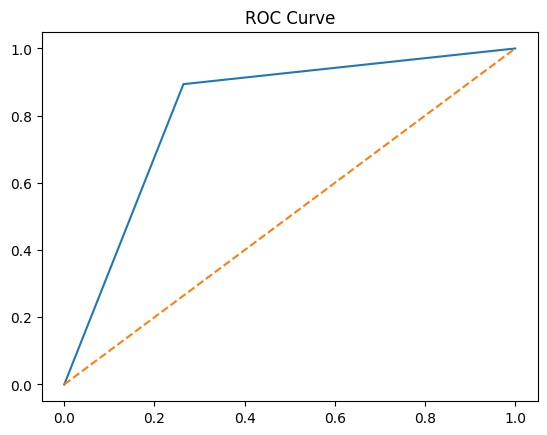

In [13]:
fpr, tpr, thresholds = roc_curve(y_holdout, y_holdout_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC Curve')

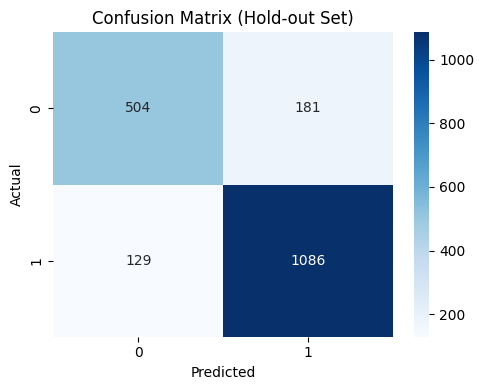

In [10]:
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_holdout, y_holdout_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Hold-out Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [6]:
joblib.dump(ensemble1, 'model.pkl')

['model.pkl']